In [1]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)

from streamsculptor import potential
from streamsculptor import JaxCoords as jc



In [2]:
from streamsculptor.potential import MW_LMC_Potential
# Intialization of this class takes a moment: 
# splines are fit on the fly for the MW and LMC (all with jit)
pot_MWLMC = MW_LMC_Potential(units=usys)


In [3]:
## Define icrs to OC frame [phi1, phi2]
@jax.jit
def icrs_to_OC(ra_rad, dec_rad):
    R = jnp.array(
        [
            [-0.44761231, -0.08785756, -0.88990128],
            [-0.84246097, 0.37511331, 0.38671632],
            [0.29983786, 0.92280606, -0.2419219],
        ]
    )


    icrs_vec = jnp.vstack([jnp.cos(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(dec_rad)]).T

    stream_frame_vec = jnp.einsum('ij,kj->ki',R,icrs_vec)
    
    phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
    phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi

    
    return phi1, phi2

@jax.jit
def OC_to_icrs(phi1, phi2):
    """
    phi1, phi2 in RADIANS
    output in degrees
    """
    R_icrs_to_OC = jnp.array(
        [
            [-0.44761231, -0.08785756, -0.88990128],
            [-0.84246097, 0.37511331, 0.38671632],
            [0.29983786, 0.92280606, -0.2419219],
        ]
    )
    
    R_OC_to_icrs = jnp.linalg.inv(R_icrs_to_OC)
    
    OC_vec = jnp.vstack([jnp.cos(phi1)*jnp.cos(phi2),
                           jnp.sin(phi1)*jnp.cos(phi2),
                           jnp.sin(phi2)]).T
    
    icrs_vec = jnp.einsum('ij,kj->ki',R_OC_to_icrs,OC_vec)
    
    ra = jnp.arctan2(icrs_vec[:,1],icrs_vec[:,0])*180/jnp.pi
    dec = jnp.arcsin(icrs_vec[:,2])*180/jnp.pi
    
    return ra, dec

In [4]:
# OC stream - defining present-day location of progenitor
# COLUMN 1 of https://arxiv.org/pdf/1812.08192
phi1_prog = jnp.deg2rad(6.34)
phi2_prog = jnp.deg2rad(-0.441)
dist_prog = 18.764 ## kpc
vr_prog = 107.573 ## km/s
pmdec_prog = 2.880 ## mas/yr
pmra_prog = -3.681 ##mas/yr
ra_prog, dec_prog = OC_to_icrs(phi1_prog, phi2_prog) ## deg
ra_prog_rad = jnp.deg2rad(ra_prog)
dec_prog_rad = jnp.deg2rad(dec_prog)

# Use internal functions to convert ra,dec,dist to cartesian coordinates
xprog, yprog, zprog = jc.alpha_delta_to_simcart(jnp.array([ra_prog_rad[0],dec_prog_rad[0],dist_prog]))
# Use astropy to convert proper motions and radial velocity to cartesian velocities
galactic_coords = SkyCoord(ra=ra_prog[0]*u.deg, dec=dec_prog[0]*u.deg, 
                              distance=dist_prog*u.kpc, pm_ra_cosdec=pmra_prog*u.mas/u.yr, 
                              pm_dec=pmdec_prog*u.mas/u.yr, radial_velocity=vr_prog*u.km/u.s, frame='icrs').transform_to(Galactocentric)

q_prog =  jnp.hstack([xprog, yprog, zprog])
p_prog = jnp.hstack([
    galactic_coords.v_x.to(u.kpc/u.Myr).value, 
    galactic_coords.v_y.to(u.kpc/u.Myr).value,
    galactic_coords.v_z.to(u.kpc/u.Myr).value])

prog_wf = jnp.hstack([q_prog, p_prog])

In [5]:
## In MW-LMC potential integrate back, and then generate stream forward
tback = -4000.0
Init_Cond = pot_MWLMC.integrate_orbit(w0=prog_wf, t0=0.0, t1=tback, ts=jnp.array([tback])).ys[0]
## Define stripping times for stream
ts= jnp.hstack([jnp.linspace(tback,-150,3_000),jnp.array([0.0])])
stream_lead, stream_trail = pot_MWLMC.gen_stream_scan(prog_w0=Init_Cond,ts=ts, Msat=1e6, seed_num=9302)
stream_MWLMC = jnp.vstack([stream_lead, stream_trail])

In [6]:
## Now do the same in a static potential. No time-dependence, no LMC
pot_MW = potential.GalaMilkyWayPotential(units=usys)
Init_Cond = pot_MW.integrate_orbit(w0=prog_wf, t0=0.0, t1=tback, ts=jnp.array([tback])).ys[0]
stream_lead, stream_trail = pot_MW.gen_stream_vmapped(prog_w0=Init_Cond,ts=ts, Msat=1e6, seed_num=9302, throw=False,max_steps=1_000)
stream_static = jnp.vstack([stream_lead, stream_trail])

In [7]:
stream_lead

Array([[-2.04052860e+01, -7.68047788e+00,  1.95803535e+01,
        -1.78027210e-01,  1.38205565e-01,  1.35540104e-01],
       [-2.39083893e+01, -4.66595762e+00,  2.22603463e+01,
        -1.58322958e-01,  1.43156078e-01,  1.14069717e-01],
       [-3.46997851e+01,  8.07260674e+00,  2.91083448e+01,
        -8.96025650e-02,  1.38183738e-01,  5.07815127e-02],
       ...,
       [ 9.54115332e-02, -1.55918830e+01,  2.55197359e+00,
        -2.64576956e-01,  1.17534592e-02,  2.38868685e-01],
       [ 1.31897624e-01, -1.59661178e+01,  2.59713708e+00,
        -2.62162798e-01,  8.27834289e-03,  2.38162800e-01],
       [-2.86919825e-01, -1.58838413e+01,  2.70029051e+00,
        -2.59500471e-01,  1.17199051e-02,  2.40446802e-01]],      dtype=float64)

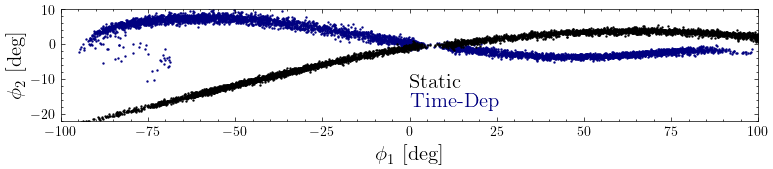

In [8]:
## Visualize, by transforming to phi1-phi2 frame
model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(stream_MWLMC[:,:3])
phi1_MWLMC, phi2_MWLMC = icrs_to_OC(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))

model_ra, model_dec, model_dist = jax.vmap(jc.simcart_to_icrs,in_axes=((0,)))(stream_static[:,:3])
phi1_static, phi2_static = icrs_to_OC(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))

fig, ax = plt.subplots(1,1)
fig.set_size_inches(9,8)
ax.scatter(phi1_MWLMC,phi2_MWLMC,s=.5,color='navy',label='Time-Dep.')
ax.scatter(phi1_static,phi2_static,s=.5,color='k',label='Static')

ax.text(0,-12.5,'Static',fontsize=15)
ax.text(0,-18,'Time-Dep',fontsize=15,color='navy')

ax.set_xlim(-100,100)
ax.set_ylim(-22,10)

ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=15)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=15)
ax.set_aspect('equal')

In [9]:
## Now let's visualize the velocities (or proper motions) in the phi1-phi2 frame

## first we use Jax and auto-diff to get the unit vectors
@jax.jacfwd
@jax.jit
def get_unit_vec(stream_pos):
    model_ra, model_dec, model_dist = jc.simcart_to_icrs(stream_pos)
    p1, p2 = icrs_to_OC(jnp.deg2rad(model_ra), jnp.deg2rad(model_dec))
    return p1, p2

@jax.jit
def get_vphi12(stream):
    derivs = jax.vmap(get_unit_vec,in_axes=(0,))(stream[:,:3])
    dphi1_dx = derivs[0][:,0,:]
    dphi2_dx = derivs[1][:,0,:]

    dphi1_dx_unit = dphi1_dx / (jnp.sqrt(jnp.sum(dphi1_dx**2,axis=1))[:,None])
    dphi2_dx_unit = dphi2_dx / (jnp.sqrt(jnp.sum(dphi2_dx**2,axis=1))[:,None])

    vel_phi1 = jnp.sum(stream[:,3:]*dphi1_dx_unit,axis=1)
    vel_phi2 = jnp.sum(stream[:,3:]*dphi2_dx_unit,axis=1)

    return vel_phi1, vel_phi2



vel_phi1_MWLMC, vel_phi2_MWLMC = get_vphi12(stream_MWLMC)
vel_phi1_static, vel_phi2_static = get_vphi12(stream_static)


In [10]:
## Define function that computes the average velocity in phi1 bins, and the average phi2 in phi1 bins
from scipy.stats import binned_statistic
import numpy as np
def get_binned_stat(phi1, phi2, vel_phi1, vel_phi2, bins):
    H_vphi1 = binned_statistic(phi1,vel_phi1,bins=bins,statistic='mean')
    H_vphi2 = binned_statistic(phi1,vel_phi2,bins=bins,statistic='mean')

    phi1_centers = (H_vphi1[1][:-1] + H_vphi1[1][1:]) / 2
    phi2_binned = binned_statistic(phi1,phi2,bins=bins,statistic='mean')
    phi2_centers = (phi2_binned[1][:-1] + phi2_binned[1][1:]) / 2
    return H_vphi1, H_vphi2, phi1_centers, phi2_binned[0]

bins=np.linspace(-100,95,13)
H_vphi1_MWLMC, H_vphi2_MWLMC, phi1_centers_MWLMC, phi2_centers_MWLMC = get_binned_stat(phi1_MWLMC, phi2_MWLMC, vel_phi1_MWLMC, vel_phi2_MWLMC, bins)
H_vphi1_static, H_vphi2_static, phi1_centers_static, phi2_centers_static = get_binned_stat(phi1_static, phi2_static, vel_phi1_static, vel_phi2_static, bins)

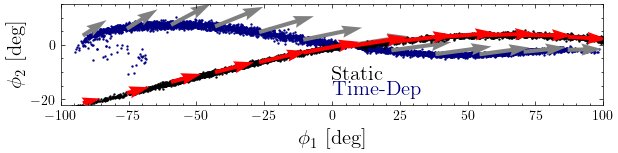

In [11]:
## plot streams and velocity vectors
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,4)
ax.scatter(phi1_MWLMC, phi2_MWLMC,color='navy',s=.5 )
s=1
ax.quiver(phi1_centers_MWLMC[::s], phi2_centers_MWLMC[::s],H_vphi1_MWLMC[0][::s],H_vphi2_MWLMC[0][::s] ,color='gray',scale=3)


ax.scatter(phi1_static, phi2_static,color='k',s=.5 )
ax.quiver(phi1_centers_static[::s], phi2_centers_static[::s],H_vphi1_static[0][::s],H_vphi2_static[0][::s] ,color='r',scale=3)


ax.set_xlim(-100,100)
ax.set_ylim(-22,15)

ax.text(0,-12.5,'Static',fontsize=15)
ax.text(0,-18,'Time-Dep',fontsize=15,color='navy')



ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=15)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=15)
ax.set_aspect('equal')

In [12]:
## Velocity vectors in time-dep model are offset from the track. Static model shows no such misalignment.